In [229]:
import pandas as pd
import json
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib
import math
try:
    from kneed import KneeLocator
except:
    !pip install kneed
    from kneed import KneeLocator


In [115]:
json_file_name = r"via_export_coco (1).json"

In [116]:
with open(json_file_name, 'r') as fp:
    json_data = json.loads(fp.read())

In [117]:
json_data.keys()

dict_keys(['info', 'images', 'annotations', 'licenses', 'categories'])

I have taken the COCO format json.
Out of all the attributes in the json, we mainly require three attributes from it.
* images
> Each element in the list points to a dataset record. It contains size the name of the image ```file_name```, assigned an unique identifier ```id```, and the size of the image as ```width``` and ```height```

* categories
> category contains the class tagged as ```supercategory```  and the value of the class as ```name``` and an unique identifier for each combination of ```supercategory``` and its value to identify what the bbox is signifying

 annotations
> * ```annotation``` contains a record for every bbox tagged. each bbox is identified as ```id```. 
> * The attribure ```image_id``` points to the unique dataset image from the ```images``` attribute.
> * Similarly ```category_id``` refers to the ```supercategory```unique value i.e. ```id``` from categories attribute.
> * bbox is the cooridinated of the bbox in sequence of coordinates ```x```, ```y```, ```width```, ```height```.
> * ```segmentation```  attribure contains the ccordinate of all the edges of bbox tagged in which every coordinates are in pair as ```x```, ```y```. 

In [118]:
len(json_data["images"]), len(json_data['annotations'])

(50, 54)

In [203]:
annotated_data= []

for idx, file_data in enumerate(json_data["images"]):
    for rec in list(filter(lambda x : (int(x["image_id"]) == file_data["id"]) , json_data['annotations'])):
        temp_ = {}
        temp_["file_id"] = file_data["id"]        
        temp_["file_name"] = file_data["file_name"]
        temp_["size_width_height_original"] = (file_data["width"], file_data["height"])
        temp_["size_width_height_norm"] = (file_data["width"]//file_data["width"], file_data["height"]//file_data["height"])
        temp_["class"] = json_data['categories'][idx]["name"]
        temp_["coordinates_x_y_original"] = tuple(rec["bbox"][:2])
        temp_["coordinates_x_y_norm"] = tuple([round(rec["bbox"][0]/file_data["width"], 3), round(rec["bbox"][1]/file_data["height"],3)])
        temp_["coordinates_width_height_original"] = tuple(rec["bbox"][-2:])
        temp_["coordinates_width_height_norm"] = tuple([round(rec["bbox"][2]/file_data["width"], 3), round(rec["bbox"][3]/file_data["height"],3)])

        annotated_data.append(temp_)

    
    
annotated_data
    
df = pd.DataFrame.from_dict(annotated_data)
df.head()
    

,file_id,file_name,size_width_height_original,size_width_height_norm,class,coordinates_x_y_original,coordinates_x_y_norm,coordinates_width_height_original,coordinates_width_height_norm
0,0,dog.3000.jpg,"(448, 335)","(1, 1)",Dog,"(59, 10)","(0.132, 0.03)","(253, 318)","(0.565, 0.949)"
1,1,dog.3001.jpg,"(359, 270)","(1, 1)",Dog,"(11, 109)","(0.031, 0.404)","(107, 85)","(0.298, 0.315)"
2,1,dog.3001.jpg,"(359, 270)","(1, 1)",Dog,"(121, 93)","(0.337, 0.344)","(91, 106)","(0.253, 0.393)"
3,1,dog.3001.jpg,"(359, 270)","(1, 1)",Dog,"(241, 74)","(0.671, 0.274)","(102, 87)","(0.284, 0.322)"
4,2,dog.3002.jpg,"(374, 500)","(1, 1)",Dog,"(18, 27)","(0.048, 0.054)","(325, 453)","(0.869, 0.906)"


In [280]:
def IOU(box1, box2):
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    w_intersection = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_intersection = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_intersection <= 0 or h_intersection <= 0: # No overlap
        return 0
    I = w_intersection * h_intersection
    U = w1 * h1 + w2 * h2 - I # Union = Total Area - I
    return I / U

In [204]:
height = [_[1] for _ in df["coordinates_width_height_norm"].tolist()]
width = [_[0] for _ in df["coordinates_width_height_norm"].tolist()]

In [205]:

# ax.set_xlabel("x")

In [206]:
def plot_bbox(width, height, plot_log= False):
    plt.figure(figsize=[10,6])
    width = np.log(width) if plot_log is True else width
    height = np.log(height) if plot_log is True else height
    x_label = "Width"  if plot_log is not True else "Log Width"
    y_label = "Height"  if plot_log is not True else "Log Height"

    plt.scatter(width, height)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{y_label} vs {x_label}")
    plt.show()

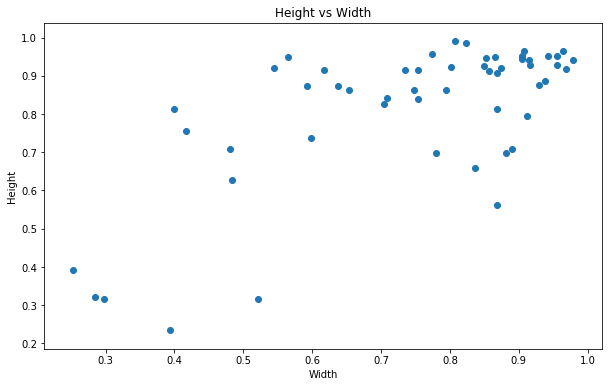

In [207]:
plot_bbox(width, height)

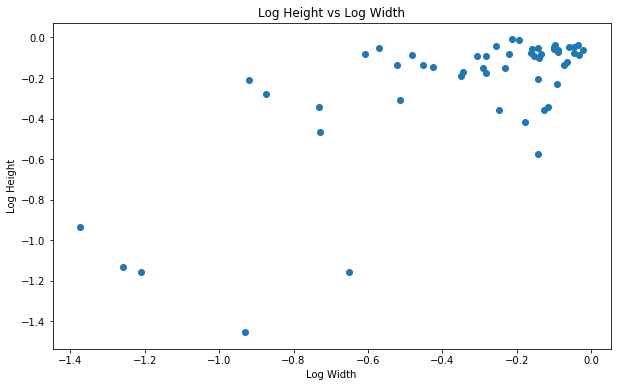

In [208]:
plot_bbox(width, height, plot_log=True)

In [274]:
def plot_elbow(width, height, plot_log=False):
    width = np.log(width) if plot_log is True else width
    height = np.log(height) if plot_log is True else height
    label = "Log"  if plot_log is True else ""
    wcss = []
    kn = KneeLocator(width, height,S=1.0, curve='convex', direction='decreasing')
    for i in range(1, 11):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0, verbose=False)
        kmeans.fit([_ for _ in zip(width, height)])
        wcss.append(kmeans.inertia_)
    plt.figure(figsize=[10,6])
    plt.plot(range(1, 11), wcss)
    plt.title(f"{label} Elbow Method".strip())
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()



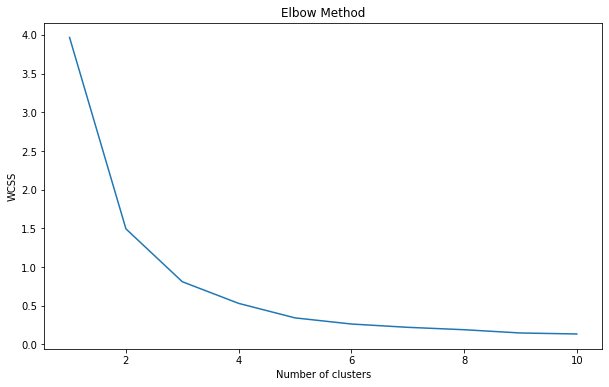

In [275]:
plot_elbow(width, height, plot_log=False) 

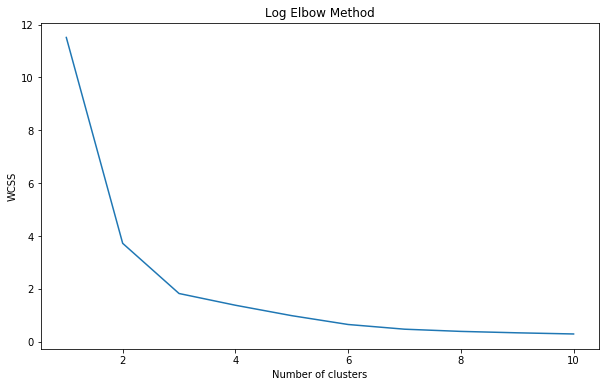

In [276]:
plot_elbow(width, height, plot_log=True) 

In [277]:
def get_centroids(width, height, num_clusters, plot_log = False):
    width = np.log(width) if plot_log is True else width
    height = np.log(height) if plot_log is True else height
    x_label = "Width"  if plot_log is not True else "Log Width"
    y_label = "Height"  if plot_log is not True else "Log Height"
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    pred_y = kmeans.fit_predict([_ for _ in zip(width, height)])
    plt.figure(figsize=[10,6])
    plt.scatter(width, height, c=[matplotlib.cm.get_cmap("Spectral")(float(i) /10) for i in kmeans.labels_])
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=200, c='red')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"{y_label} vs {x_label}")
    plt.show()
    

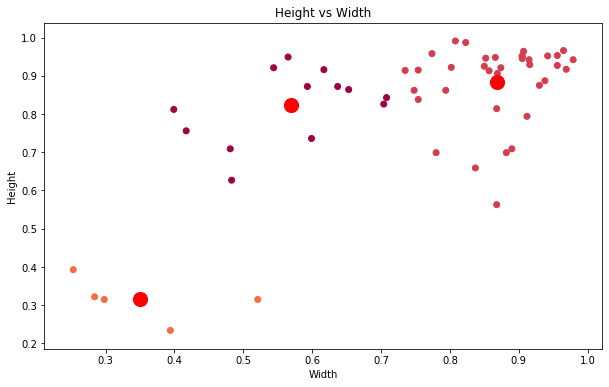

In [278]:
get_centroids(width, height, 3)

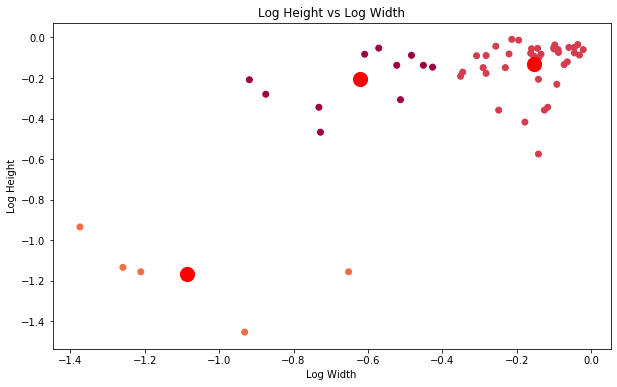

In [279]:
get_centroids(width, height, 3, plot_log=True)